# Challenge HS19C5 - Wettermonitor für Wassersportler, Documentation

#### Aufgabestellung: 
Der Segelclub Zürichsee beauftragt Sie, für die Clubmitglieder einen Wettermonitor zu bauen. Der Wettermonitor wird neben den Bootsliegeplätzen über einen Bildschirm Wetterdaten für Segler und andere Wassersportler auf hilfreiche Weise darstellen, sodass Segler sie unter anderem zur Planung eines Segeltörns nutzen können. 

Ausserdem sollen Vergleichsdaten aus der Vergangenheit dargestellt werden. Können aus diesen Rückschlüssen auf mögliche Wetter-Entwicklungen gezogen werden, soll das ebenfalls angezeigt werden.

Als Hardware für den Wettermonitor steht ihnen ein Raspberry Pi Computer mit Monitor zur Verfügung. Die Wetterdaten holen Sie sich fortlaufend von einem Webservice der Seepolizei Zürich und speichern sie in einer Datenbank auf dem Raspberry Pi. Die Software soll hauptsächlich in Python programmiert werden.

Wir gehen davon aus, dass später einmal andere Datenquellen angeschlossen werden sollen oder Erfahrungen von Nutzern über die Zeit hinweg zu Änderungswünschen führen. Solche Veränderungen an der Software müssen dann auch Ihnen fremde Programmierer machen können.

Quelle: [DS_Spaces, Challenge Wettermonitor](https://ds-spaces.technik.fhnw.ch/wettermonitor-hs2019/#book)



In [1]:
import sys
!{sys.executable} -m pip install pandas-profiling fitter chart-studio plotly
import pandas as pd
import pandas_profiling
from csv import reader
import statsmodels.api as sm
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
import seaborn as sns; sns.set_style("dark")
import matplotlib.pyplot as plt
import missingno
from statsmodels.tsa import seasonal_d
from math import radians
import datetime
import warnings
import numpy as np
import scipy
import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt
from fitter import Fitter
from datetime import timedelta
import plotly as ply
import plotly.graph_objects as go
import chart_studio.plotly as py

Der Befehl "C:\Users\Roman" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


# 1. Setup Services
#### Installation InfluxDB
Download: [Influx DB, V. 1.7.8](https://portal.influxdata.com/downloads/)

Bearbeitung der Config-Datei:
1. Ordner "data","meta,"val" erstellen
2. Config-File mit den Pfaden der neu erstellten Ordner erweitern

Starten der InfluxDB:
1. Infuxdb.exe starten (Startet die Datenbank)
2. Inluxd.exe starten (Startet das Terminal)
3. Mit `SHOW DATABASES`kann zum Beispiel im Terminal die Datenbanken angezeigt werden. Vor dem erstellen der Wetter-DB ist nur die ___ _internal___ Datenbank zu sehen


# 2. EDA
Der EDA Prozess wird mit dem Einlesen der CSV's begonnen. Zu Beginn arbeite ich nun ausschliesslich mit dem CSV "Messwerte_Mythenquai_2019.csv" und dem CSV "Messwerte_Tiefenbrunnen_2019.csv"

Ziele des EDA-Prozesses:
- Dataset kennen lernen und erste Vermutungen über Zusammenhänge anstellen
- Dataset vorbereiten oder bereinigen damit mit den Daten gearbeitet werden kann (Data Cleansing)
- Besseres Verständnis über die Daten und somit erste Ideen kriegen wie diese Visualisiert werden könnten

In [2]:
open_file = open('../wetterstation/data/messwerte_mythenquai_2019.csv')
open_file_2 = open('../wetterstation/data/messwerte_tiefenbrunnen_2019.csv')

#reads mythenquai and tiefenbrunnen Messwerte
myth = pd.read_csv('../wetterstation/data/messwerte_mythenquai_2019.csv') #myth is short for Mythenquai
tief = pd.read_csv('../wetterstation/data/messwerte_tiefenbrunnen_2019.csv') #tief is short for Mythenquai
myth_old = pd.read_csv('../wetterstation/data/messwerte_mythenquai_2007-2018.csv')
tief_old = pd.read_csv('../wetterstation/data/messwerte_tiefenbrunnen_2007-2018.csv')

In [3]:
#Profiling Function for firsthand data analysis:
#myth.profile_report()

In [4]:
myth.head()

timestamp_cet  air_temperature  barometric_pressure_qfe  \
0  2019-01-07 23:10:00+00:00              3.0                    981.0   
1  2019-01-07 23:20:00+00:00              2.9                    980.9   
2  2019-01-07 23:30:00+00:00              2.8                    980.7   
3  2019-01-07 23:40:00+00:00              2.8                    980.4   
4  2019-01-07 23:50:00+00:00              2.8                    980.3   

   dew_point  global_radiation  humidity  precipitation  water_temperature  \
0        0.1               0.0      81.0            0.0                6.2   
1        0.0               0.0      81.0            0.0                6.2   
2        0.1               0.0      82.0            0.0                6.2   
3        0.2               0.0      83.0            0.0                6.2   
4        0.3               0.0      83.0            0.0                6.2   

   wind_direction  wind_force_avg_10min  wind_gust_max_10min  \
0           273.0                   2.0                  5.3   
1           273.0                   2.0                  4.5   
2           307.0                   2.0                  6.8   
3           290.0                   2.0                  3.3   
4           287.0                   1.0                  3.4   

   wind_speed_avg_10min  windchill  
0                   2.6        0.0  
1                   2.2        0.9  
2                   3.1       -0.2  
3                   1.9        1.2  
4                   1.5        1.8

**Einheiten der Variablen im Mythenquai Dataset**

<table><tr>
    <td><b>Variable</b></td><td><b>Einheit</b></tr>
    <tr><td>timestamp_cet</td><td>Format: %YY-%MM%-%DD %HH:%MM:%%SS</td>
    <tr><td>air_temperature</td><td>°C</td>
    <tr><td>barometric_pressure_qfe</td><td>hPa</td>
    <tr><td>dew_point</td><td>°C</td>
    <tr><td>global_radiation</td><td>W/m²</td>
    <tr><td>humidity</td><td>%</td>
    <tr><td>precipitation</td><td>Summe mm</td>
    <tr><td>water_temperature</td><td>°C</td>
    <tr><td>wind_direction</td><td>°</td>
    <tr><td>wind_force_avg_10min</td><td>bft</td>
    <tr><td>wind_gust_max_10min</td><td>m/s</td>
    <tr><td>wind_speed_avg_10min</td><td>m/s</td>
    <tr><td>windchill</td><td>°C</td>   

In [5]:
tief.head()

timestamp_cet  air_temperature  barometric_pressure_qfe  \
0  2019-01-07 23:10:00+00:00              3.3                    981.0   
1  2019-01-07 23:20:00+00:00              3.2                    980.9   
2  2019-01-07 23:30:00+00:00              3.2                    980.7   
3  2019-01-07 23:40:00+00:00              3.2                    980.5   
4  2019-01-07 23:50:00+00:00              3.2                    980.3   

   dew_point  humidity  water_temperature  wind_direction  \
0        0.5      82.0                6.2           177.0   
1        0.3      81.0                6.2           210.0   
2        0.5      82.0                6.2           174.0   
3        0.5      82.0                6.2           101.0   
4        0.6      83.0                6.2            41.0   

   wind_force_avg_10min  wind_gust_max_10min  wind_speed_avg_10min  windchill  
0                   2.0                  3.9                   2.1        1.8  
1                   1.0                  2.6                   1.0        3.1  
2                   1.0                  3.6                   1.0        2.8  
3                   2.0                  4.6                   2.0        1.5  
4                   1.0                  2.4                   1.0        3.1

## 2.1 Unterschiede im Dataset
Es gibt einige Unterschiede zwischen den beiden Datasets. Welche für den weiteren Prozess relevant sein könnten.

### 2.1.1 Unterschiedliche Spalten
Das Dataset myth hat 13 Spalten mit folgenden Namen:
- 'timestamp_cet' 
- 'air_temperature'
- 'barometric_pressure_qfe'
- 'dew_point'
- 'global_radiation'
- 'humidity', 'precipitation'
- 'water_temperature'
- 'wind_direction'
- 'wind_force_avg_10min',
- 'wind_gust_max_10min'
- 'wind_speed_avg_10min'
- 'windchill'

Währenddessen hat das Dataset tief nur 11 Spalten. Die fehlenden sind rot markiert:

- 'timestamp_cet'
- 'air_temperature'
- 'barometric_pressure_qfe'
- 'dew_point'
- 'humidity'
- 'water_temperature'
- 'wind_direction',
- 'wind_force_avg_10min'
- 'wind_gust_max_10min'
- 'wind_speed_avg_10min'
- 'windchill'

Columns die im Dataset tief nicht vorkommen:
- <font color='red'>'global_radiation'</font>
- <font color='red'>'precipitation'</font>

In [6]:
#Look at Columns in dataset myth
print(len(myth.columns))
myth.columns

13


Index(['timestamp_cet', 'air_temperature', 'barometric_pressure_qfe',
       'dew_point', 'global_radiation', 'humidity', 'precipitation',
       'water_temperature', 'wind_direction', 'wind_force_avg_10min',
       'wind_gust_max_10min', 'wind_speed_avg_10min', 'windchill'],
      dtype='object')

In [7]:
#Look at Columns in dataset tief
print(len(tief.columns))
tief.columns

11


Index(['timestamp_cet', 'air_temperature', 'barometric_pressure_qfe',
       'dew_point', 'humidity', 'water_temperature', 'wind_direction',
       'wind_force_avg_10min', 'wind_gust_max_10min', 'wind_speed_avg_10min',
       'windchill'],
      dtype='object')

In [8]:
#search for the missing columns in the tief.columns dataset
for i in myth.columns:
    if i not in tief.columns:
        print(i)

global_radiation
precipitation


### 2.1.2 Generelle Informationen zu beiden Datasets
Betrachten wir nun den Inhalt der Datasets mit der pandas Funktion `info()`. 
Es fällt auf das Alle Spalten die gleiche Anzahl an "non-null" werten haben, welche auch der anzahl Reihen im Dataset entspricht. Das sagt uns das wir vermutlich keine "missing values" oder Nan-Values haben. Trotzdem prüfe ich das noch in einem späteren Schritt. Hätten wir Spalten mit sehr wenigen non-null Werten im Vergleich zu anderen Spalten müsste man hier in erwägung ziehen diese Spalten für weitere Schritte (zum Beispiel zum erstellen eines Modelles) nicht zu verwenden da sie keine Aussagekraft besitzen.

Dataset myth:
 Enthält 31'000 Datenpunkte und abgesehen von der Spalte 'timestamp_cet' (object) sind alle Werte vom Typ float64
 
Dataset tief:
 Enthält 30'956 Datenpunkte (etwas weniger als im Dataset myth) und hat ebenfalls von der Spalte 'timestamp_cet' nur Wete vom Typ float 64

In [9]:
#general Information on the dataset myth
myth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44707 entries, 0 to 44706
Data columns (total 13 columns):
timestamp_cet              44707 non-null object
air_temperature            44707 non-null float64
barometric_pressure_qfe    44707 non-null float64
dew_point                  44707 non-null float64
global_radiation           44707 non-null float64
humidity                   44707 non-null float64
precipitation              44707 non-null float64
water_temperature          44707 non-null float64
wind_direction             44707 non-null float64
wind_force_avg_10min       44707 non-null float64
wind_gust_max_10min        44707 non-null float64
wind_speed_avg_10min       44707 non-null float64
windchill                  44707 non-null float64
dtypes: float64(12), object(1)
memory usage: 4.4+ MB


In [10]:
myth.isna().sum()
#it seems that we have no missing values

timestamp_cet              0
air_temperature            0
barometric_pressure_qfe    0
dew_point                  0
global_radiation           0
humidity                   0
precipitation              0
water_temperature          0
wind_direction             0
wind_force_avg_10min       0
wind_gust_max_10min        0
wind_speed_avg_10min       0
windchill                  0
dtype: int64

In [11]:
myth.describe()

air_temperature  barometric_pressure_qfe     dew_point  \
count     44707.000000             44707.000000  44707.000000   
mean         12.981578               815.730534      6.343382   
std           7.796698               348.066178      6.073032   
min          -3.900000                18.000000     -7.900000   
25%           7.100000               957.800000      1.500000   
50%          12.900000               967.300000      5.200000   
75%          18.500000               971.600000     11.400000   
max          37.400000               988.200000     24.600000   

       global_radiation      humidity  precipitation  water_temperature  \
count      44707.000000  44707.000000   44707.000000       44707.000000   
mean         128.748086     62.103653      21.613461          13.804861   
std          226.370135     30.662452      69.567994           6.786303   
min            0.000000      0.000000       0.000000           4.500000   
25%            0.000000     50.000000       0.000000           6.500000   
50%            2.000000     72.000000       0.000000          13.700000   
75%          155.000000     86.000000       0.000000          18.700000   
max         1000.000000    100.000000     360.000000          33.600000   

       wind_direction  wind_force_avg_10min  wind_gust_max_10min  \
count    44707.000000          44707.000000         44707.000000   
mean       296.556989              1.437314             5.381034   
std        312.971262              1.072122             4.468280   
min          0.000000              0.000000             0.000000   
25%         85.000000              1.000000             2.200000   
50%        173.000000              2.000000             3.900000   
75%        320.000000              2.000000             7.400000   
max        984.100000              7.000000            23.500000   

       wind_speed_avg_10min     windchill  
count          44707.000000  44707.000000  
mean              28.869475     21.191095  
std              114.066302     25.646838  
min                0.000000     -7.700000  
25%                1.000000      5.000000  
50%                1.900000     12.400000  
75%                3.200000     22.200000  
max              938.000000     98.000000

In [12]:
#change 'wind_force_avg_10min' to a catogorical value:
myth['wind_force_avg_10min'] = myth['wind_force_avg_10min'].astype('category')
myth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44707 entries, 0 to 44706
Data columns (total 13 columns):
timestamp_cet              44707 non-null object
air_temperature            44707 non-null float64
barometric_pressure_qfe    44707 non-null float64
dew_point                  44707 non-null float64
global_radiation           44707 non-null float64
humidity                   44707 non-null float64
precipitation              44707 non-null float64
water_temperature          44707 non-null float64
wind_direction             44707 non-null float64
wind_force_avg_10min       44707 non-null category
wind_gust_max_10min        44707 non-null float64
wind_speed_avg_10min       44707 non-null float64
windchill                  44707 non-null float64
dtypes: category(1), float64(11), object(1)
memory usage: 4.1+ MB


In [13]:
#general Information on the dataset tief
tief.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44724 entries, 0 to 44723
Data columns (total 11 columns):
timestamp_cet              44724 non-null object
air_temperature            44724 non-null float64
barometric_pressure_qfe    44724 non-null float64
dew_point                  44724 non-null float64
humidity                   44724 non-null float64
water_temperature          44724 non-null float64
wind_direction             44724 non-null float64
wind_force_avg_10min       44724 non-null float64
wind_gust_max_10min        44724 non-null float64
wind_speed_avg_10min       44724 non-null float64
windchill                  44724 non-null float64
dtypes: float64(10), object(1)
memory usage: 3.8+ MB


In [14]:
#change 'wind_force_avg_10min' to a catogorical value:
tief['wind_force_avg_10min'] = tief['wind_force_avg_10min'].astype('category')

In [15]:
tief.describe()

air_temperature  barometric_pressure_qfe     dew_point      humidity  \
count     44724.000000             44724.000000  44724.000000  44724.000000   
mean         13.048035               824.168283      6.130002     61.211242   
std           7.602630               328.556612      6.065678     30.311973   
min          -3.900000                36.000000     -7.400000      0.000000   
25%           7.300000               957.700000      1.300000     50.000000   
50%          13.100000               967.200000      4.700000     71.000000   
75%          18.600000               971.600000     11.400000     84.000000   
max          35.800000               988.200000     23.400000    100.000000   

       water_temperature  wind_direction  wind_gust_max_10min  \
count       44724.000000    44724.000000         44724.000000   
mean           11.000700      134.743784             5.653155   
std             7.720393      113.475055             7.310870   
min             0.000000        0.000000             0.000000   
25%             5.200000       32.000000             0.900000   
50%            10.400000      121.000000             2.400000   
75%            16.600000      221.000000             6.500000   
max            27.900000      360.000000            24.400000   

       wind_speed_avg_10min     windchill  
count          44724.000000  44724.000000  
mean             157.469620     11.687483  
std              356.698828      7.646330  
min                0.000000     -7.200000  
25%                0.100000      6.075000  
50%                0.900000     11.500000  
75%                3.200000     16.600000  
max              984.500000     35.900000

In [16]:
tief.isna().sum()
#it seems that we have no missing values

timestamp_cet              0
air_temperature            0
barometric_pressure_qfe    0
dew_point                  0
humidity                   0
water_temperature          0
wind_direction             0
wind_force_avg_10min       0
wind_gust_max_10min        0
wind_speed_avg_10min       0
windchill                  0
dtype: int64

In [17]:
%%capture
#just in case I'm going to drop all the rows with missing values

myth.dropna(axis = 'columns')
tief.dropna(axis = 'columns')

In [18]:
#Check for dublicates:
def dub(data):
    if len(data[data.duplicated()]) > 0:
        print("No. of duplicated entries: ", len(data[data.duplicated()]))
        print(data[data.duplicated(keep=False)].sort_values(by=list(data.columns)).head())
    else:
        print("No duplicated entries found")

In [19]:
dub(myth)

No duplicated entries found


In [20]:
dub(tief)

No duplicated entries found


In [21]:
#code to drop dublicates:
#df.drop_duplicates(inplace=True)

### 2.1.3 Verteilungen
In diesem Schritt werden die Verteilungen der einzelnen Variablen im Dataset nebeneinander geplottet.
Um die Verteilungen zu visualisieren wird ein Histogramm verwendet. Für das Dataset myth wird die Farbe Blau verwendet und für das Dataset tief die Farbe Grün.

In [22]:
#select only columns with number-types data
myth_num = myth.select_dtypes(include = ['float64']) 
tief_num = tief.select_dtypes(include = ['float64'])

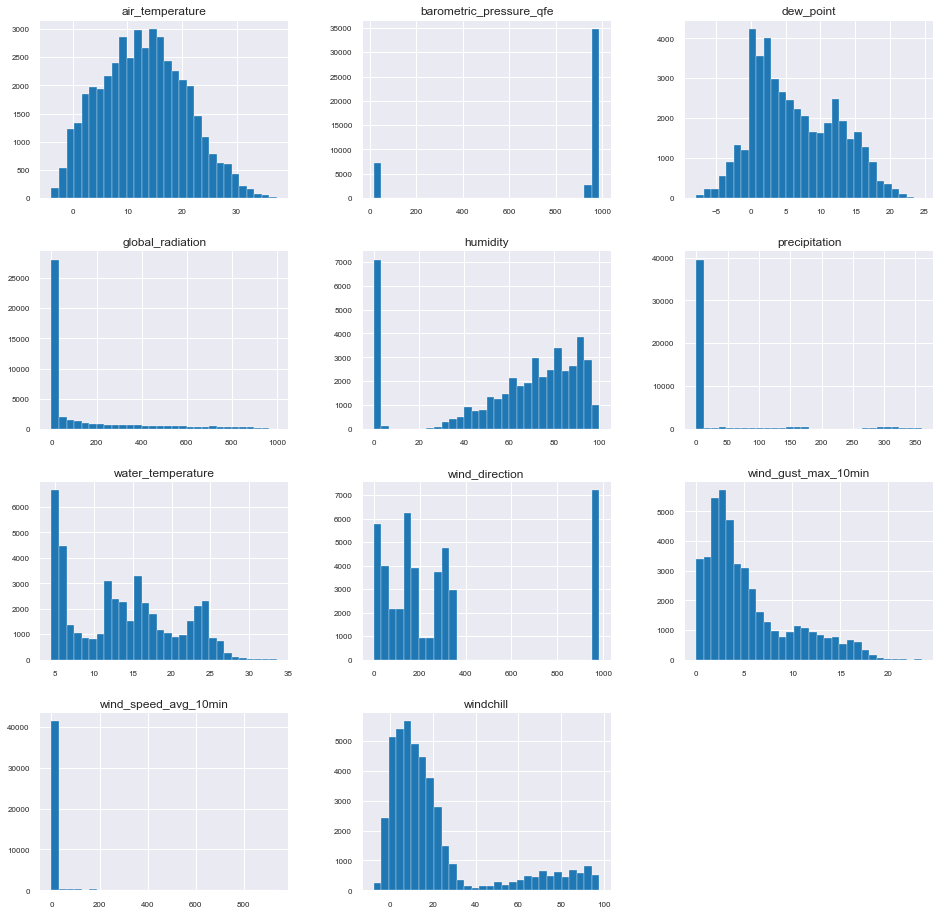

In [23]:
#plot distributions of mythenquai dataset
myth_num.hist(figsize=(16,16), bins=30, xlabelsize = 8, ylabelsize=8);

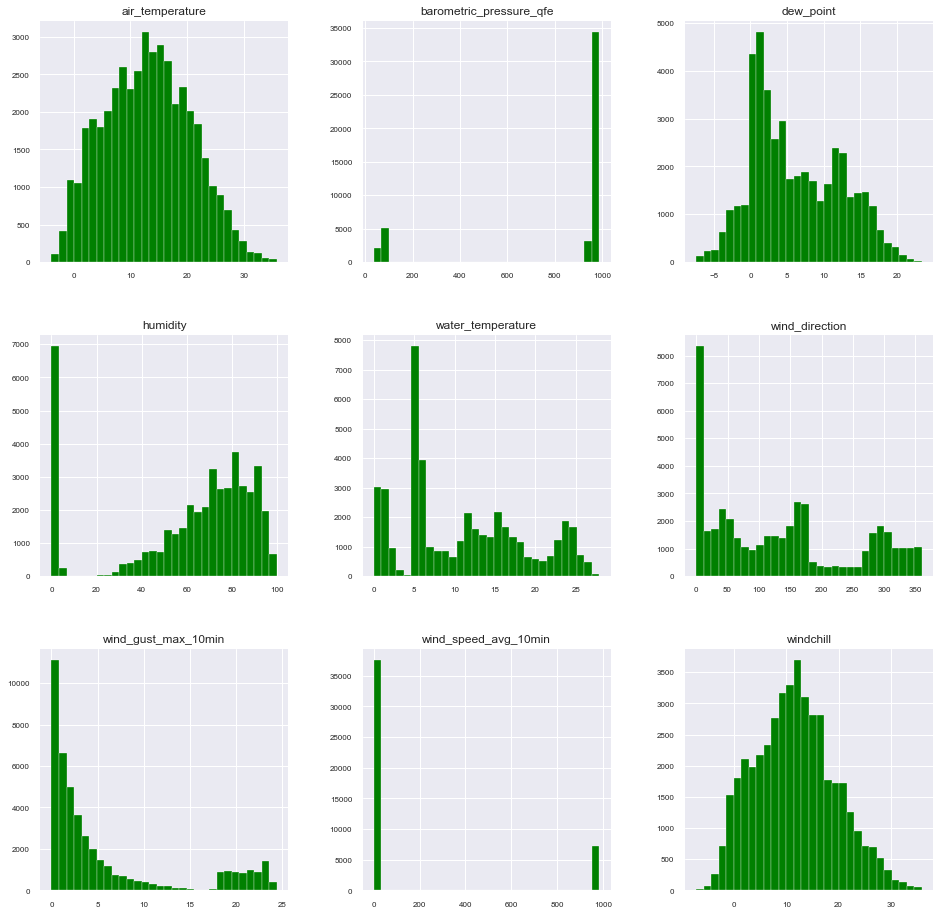

In [24]:
#plot distributions of tiefenbrunnen dataset
tief_num.hist(figsize=(16,16), bins=30, xlabelsize = 8, ylabelsize=8, color = 'green');

### 2.1.4 Korrelation testen und visualisieren
Um die Korrelation zu visualisieren wird eine Heatmap verwendet. Je grüner die Farbe umso höher die korrelation. Um die Korrelationen besser unterscheiden zu können werden weisse Linien gezogen um die Kacheln etwas lesbarer zu machen.

Die Korrelation wird mit der Methode 'Pearson' berechnet.  

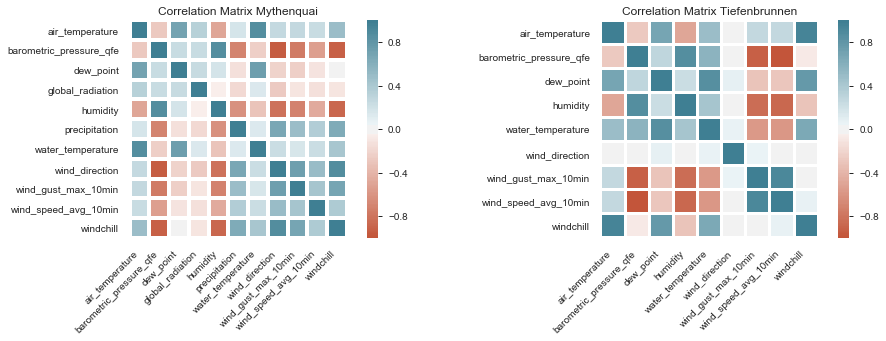

In [25]:
#Correlation Matrix Mythenquai
#create correlation between columns and create heatmap
data = myth
data_2 = tief
corr = data.corr()
corr_2 = data_2.corr()


plt.subplot(1,2,1)
plt.title('Correlation Matrix Mythenquai')
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    linewidths=3,
    
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.subplot(1,2,2)
plt.title('Correlation Matrix Tiefenbrunnen')
ax = sns.heatmap(
    corr_2, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    linewidths=2,
    
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.subplots_adjust(right = 3, left =1)
plt.show()

In [26]:
corr_2

air_temperature  barometric_pressure_qfe  dew_point  \
air_temperature                 1.000000                -0.278153   0.687086   
barometric_pressure_qfe        -0.278153                 1.000000   0.291540   
dew_point                       0.687086                 0.291540   1.000000   
humidity                       -0.487482                 0.872296   0.234232   
water_temperature               0.491256                 0.577460   0.866537   
wind_direction                  0.038959                 0.034390   0.080007   
wind_gust_max_10min             0.266349                -0.925414  -0.311669   
wind_speed_avg_10min            0.274793                -0.999606  -0.295300   
windchill                       0.949559                -0.072471   0.781067   

                         humidity  water_temperature  wind_direction  \
air_temperature         -0.487482           0.491256        0.038959   
barometric_pressure_qfe  0.872296           0.577460        0.034390   
dew_point                0.234232           0.866537        0.080007   
humidity                 1.000000           0.430168        0.031467   
water_temperature        0.430168           1.000000        0.063068   
wind_direction           0.031467           0.063068        1.000000   
wind_gust_max_10min     -0.843140          -0.578078        0.060810   
wind_speed_avg_10min    -0.873982          -0.580274       -0.036436   
windchill               -0.302195           0.649781        0.018363   

                         wind_gust_max_10min  wind_speed_avg_10min  windchill  
air_temperature                     0.266349              0.274793   0.949559  
barometric_pressure_qfe            -0.925414             -0.999606  -0.072471  
dew_point                          -0.311669             -0.295300   0.781067  
humidity                           -0.843140             -0.873982  -0.302195  
water_temperature                  -0.578078             -0.580274   0.649781  
wind_direction                      0.060810             -0.036436   0.018363  
wind_gust_max_10min                 1.000000              0.925849   0.019353  
wind_speed_avg_10min                0.925849              1.000000   0.071502  
windchill                           0.019353              0.071502   1.000000

Die Correlation Matrix zeigt uns welche Variablen zueinander korrelieren. Diese Information ist wichtig da wir damit auf diese Variablen Rückschlüsse ziehen können, welche verwendet werden um eine Voraussage auf den weiteren Wetterverlauf zu prognostizieren.

In [27]:
def plot_wind():
    name = 0
    stations_name = ['myth_old', 'myth', 'tief_old', 'tief']
    stations = [myth_old ,myth, tief_old, tief]
    for station in stations:
        x=station["timestamp_cet"][0:144]
        y0=station["wind_speed_avg_10min"][0:144]
        y1=station["wind_force_avg_10min"][0:144]
        y2=station["wind_gust_max_10min"][0:144]


        fig = go.Figure()

        fig.add_trace(go.Scatter(x=x, y=y1,
                            mode='lines',
                            name='wind force', 
                            marker=dict(color="rgb(67,67,67)")))
        fig.add_trace(go.Bar(x=x, y=y0,
                            name='avg wind speed',
                            marker=dict(color="rgb(50,205,50)")))
        fig.add_trace(go.Bar(x=x, y=y2,
                            name='max wind gust',
                            marker=dict(color="rgb(00,240,240)")))


        fig.update_layout(barmode='stack', title=('Wind over 24h, Station: {}'.format(stations_name[name])))
        fig.show()
        name += 1

In [28]:
plot_wind()

Hier ist die Korrelation zwischen den 3 Attributen sehr gut erkennbar. Steigten die Windböhen, ist auch die durchschnittliche Windgeschwindigkeit und entsprechend auch die Windstärke höher.

In [29]:
def plot_corr_temp():
    name = 0
    stations_name = ['myth_old', 'myth', 'tief_old', 'tief']
    stations = [myth_old ,myth, tief_old, tief]
    for station in stations:
        x=station["timestamp_cet"][0:288]
        y0=station["air_temperature"][0:288]
        y1=station["wind_speed_avg_10min"][0:288]
        y2=station["windchill"][0:288]


        fig = go.Figure()

        fig.add_trace(go.Scatter(x=x, y=y0,
                            mode='lines',
                            name='air temperature', 
                            marker=dict(color="rgb(255,67,67)")))

        fig.add_trace(go.Scatter(x=x, y=y1,
                            mode='lines',
                            name='avg wind speed', 
                            marker=dict(color="rgb(67,255,67)")))

        fig.add_trace(go.Scatter(x=x, y=y2,
                            mode='lines',
                            name='windchill', 
                            marker=dict(color="rgb(67,67,255)")))

        fig.update_layout(barmode='stack', title="Windchill relatet to air temperature and wind speed, Station: {}".format(stations_name[name]))
        fig.show()
        name += 1

In [30]:
plot_corr_temp()

Aus dem Diagramm ist zu erkennen, je höher die durchschnittliche Windgeschwindigkeit, umso niediger ist die gefühlte Lufttemperature im Verhältnis zur gemessenen Lufttemperatur.

#### Korrelation zwischen Luftdruck und Windstärke

Nun prüfen wir die Korrelation des Luftdruckes zur Windgeschwindigkeit und den Windspitzen bei der Station «Mythenquai».

In [31]:
def plot_corr_pressure_wind():
    
    x=myth_old["timestamp_cet"][0:5000]
    y0=myth_old["barometric_pressure_qfe"][0:5000]
    y1=myth_old["wind_force_avg_10min"][0:5000]
    #y2=myth_old["wind_direction"][0:1000]
    
    y0_normalized = (y0-y0.mean())/y0.std()
    y1_normalized = (y1-y1.mean())/y1.std()
    #y2_normalized = (y2-y2.mean())/y2.std()

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=x, y=y0_normalized,
                        mode='lines',
                        name='barometric pressure', 
                        marker=dict(color="rgb(255,67,67)")))

    fig.add_trace(go.Scatter(x=x, y=y1_normalized,
                        mode='lines',
                        name='avg wind speed', 
                        marker=dict(color="rgb(67,255,67)")))
    
    #fig.add_trace(go.Scatter(x=x, y=y2_normalized,
    #                    mode='lines',
    #                    name='wind direction', 
    #                    marker=dict(color="rgb(67,100,67)")))

    fig.update_layout(barmode='stack', title="Barometric pressure relatet to wind speed for station «Mythenquai»")

    fig.show()


# call function
plot_corr_pressure_wind()

## 2.2 Time series
Da wir mit Time Series Data arbeiten ist es sinnvoll den Verlauf der Daten über einen gewissen Zeitraum zu betrachten und ebenfalls aussauch auf einen Trendverlauf und Saisonalität zu halten. Dazu verwende ich das Additive Trend Modell welches die Daten in die Punkte Trend, Saisonalität und Noise aufteilt.

In [32]:
def timeseries(data, timeframe, color):

    data = data.iloc[timeframe:]
    i = 1
    for columData in data.columns:
        if columData != 'timestamp_cet' and columData != 'global_radiation' and columData != 'precipitation':
            plt.subplot(4,3,i)
            data[columData].plot(color = color)
            i += 1
            plt.title(columData)
    plt.subplots_adjust(right = 6, top = 4)
    plt.show()
    

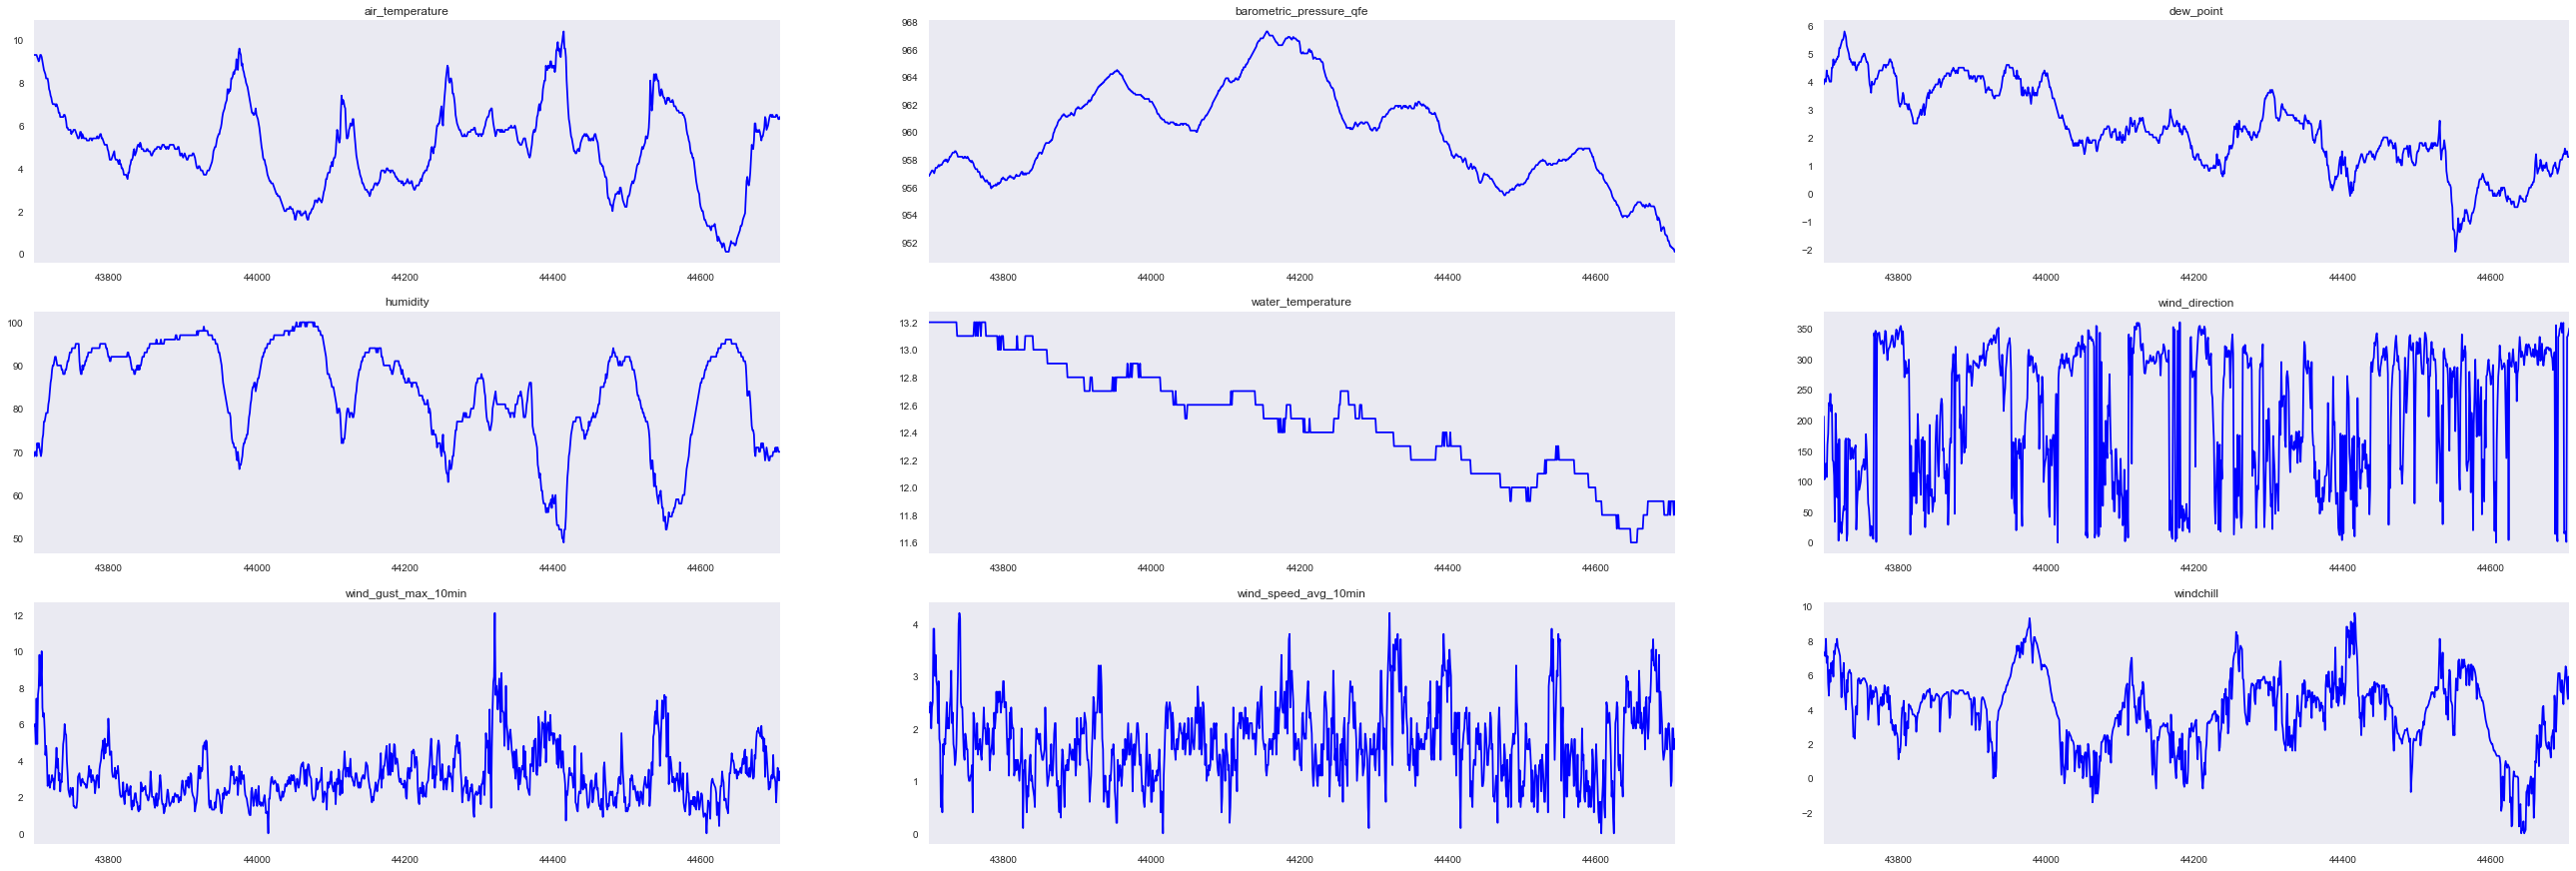

In [33]:
timeseries(myth_num, -1008, 'blue') #one week in the past

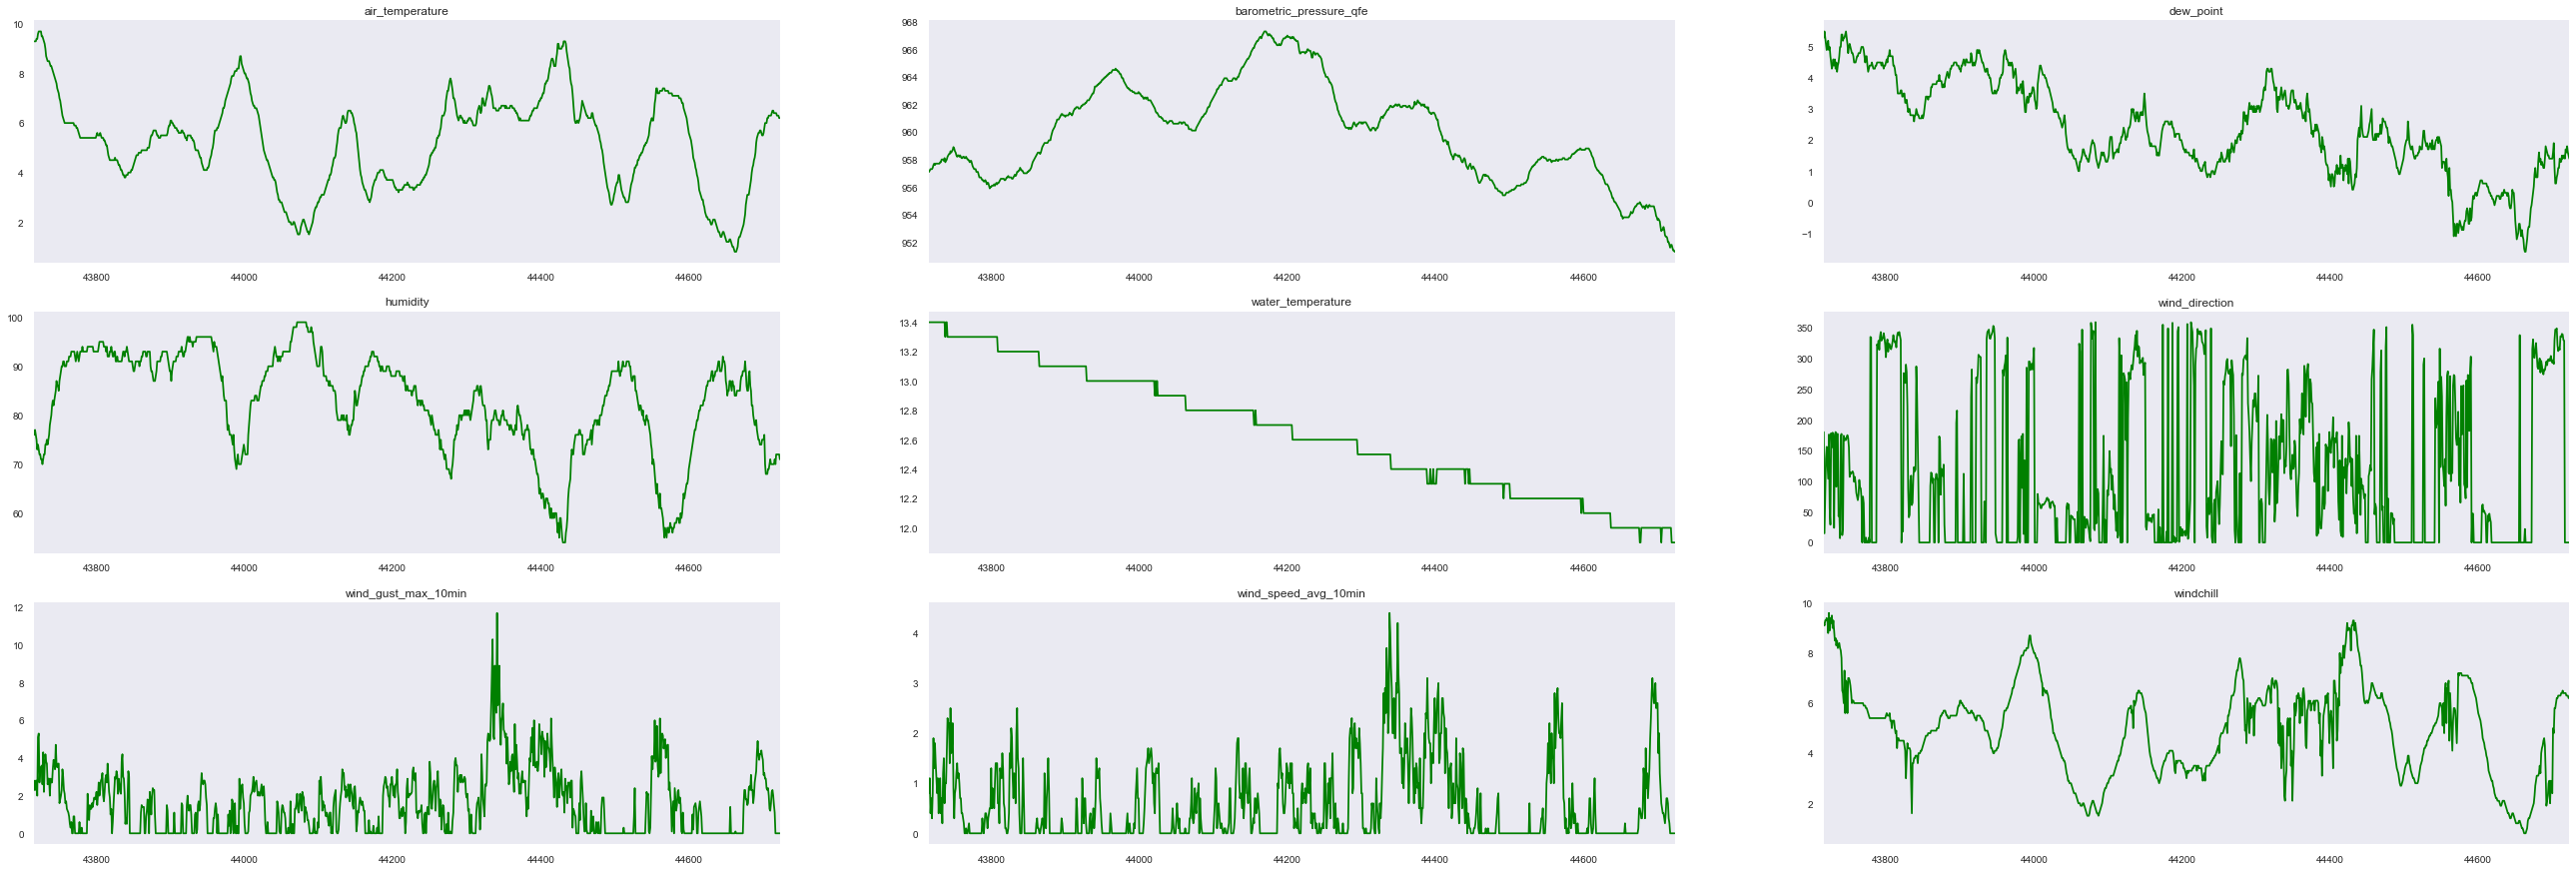

In [34]:
timeseries(tief_num, -1008, 'green') #one week in the past

## 2.3 Conclusion zum EDA-Prozess
- Das Datenset hat keine Null-Werte und beide Stationen haben fast die gleichen Variablen. Die Variable "global_radiation" ist für uns uninteressant da dieser Wert erstens nur in einem Dataset ernthalten ist und zweitens für unser Ziel nicht wichtig ist. Weiter hat nur ein Datenset die Variable 'percipitation' (engl. für Niederschlag) da die beiden Wetterstationen sehr nahe zusammen sind stellt sich nun die Frage ob diese Variable auch in das zweite Dataset übernommen werden sollte. 

- Die Daten sind alle vom Typ float64. Nur die Variable 'wind_force_avg_10min' ist eine kategorische Variable da es die Beaufortskala darstellt welche die Windstärke in 13 Kategorien (Stärken) aufteilt.

- Es gibt numerische Daten die einer Verteilung folgen könnten (zum Beispiel Lufttemperatur). Dies ist von Vorteil um später eine Vorhersage zu erstellen.

- Weiter sehen wir einen starken zusammenhang zwischen folgenden Variablen:
    - air_temperature & dew_point mit 0.87
    - air_temperature & wateremperatur mit 0.87
    - air_temperature & windchill mit 0.98
    - dew_point & water_temperatur mit 0.91
    - dew_point & windchill mit 0.87
    - water_temperature & windchill mit 0.88
    - alle drei Datenpunkte zum Wind mit plus 0.96

## 3. Datenvisualisierung
Nach dem EDA-Prozess kommt es nun dazu zu entscheiden wie die Daten am besten Visualisert werden sollten. Im Notebook hier zeige ich nur die finale Wahl des Prozesses und begründe meine Wahl in Form eines Kommentares. Da die beiden Datensets für die selben Variablen haben (mit Ausnahme von global_radiation und percipitation) werden die Visualisierungen bei beiden Sets angewandt.

### 3.1 Windrichtung
Die Windrichtung möchte ich in einer Kompassrose darstellen. Damit hätten wir eine visuelle Darstellung der Windrichtigung. Ähnlich der Anzeige auf einem Instrument. Zum Beispiel im Cockpit eines Flugzeuges.
Weiter sollte die Windrichtung auch als Text in Form von zum Beispiel NNW (Nord-Nord-West) dargestellt.

In [35]:
#function to convert winddirection in degree to winddirection as string
# Parameters: takes in a numerical value between 0 and 359
def heading(direction):
    wind = []
    heading = ['N', 'NNO','NO','ONO','O','OSO','SO','SSO','S','SSW','SW','WSW','W','WNW','NW','NNW']
    val = int((direction/22.5)+0.5)
    if val == 16:
        val = 0
    wind.append(heading[val])
    return wind

In [36]:
heading(22.5)

['NNO']

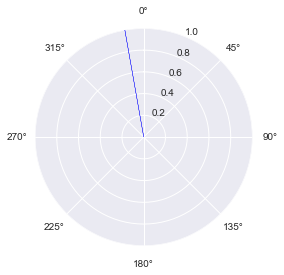

In [37]:
# Use: Plots a line to the corresponding heading of the last wind direction on a polar coordinate system to simulate a compass rose
# Parameters: dataset = Dataset containing a column called 'wind_direction' with a numerical value between 0 and 359
def compass(dataset):
    ax = plt.subplot(111, polar=True)
    ax.arrow(x=0.0,y=0.0,dx=radians(dataset.wind_direction[-1:]), dy=1.0, color = 'blue')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    
compass(myth)

## 4. Daten filtern
Da wir mit einer Timeseries Datenbank arbeiten können wir die Daten nach Datum filtern. Dadurch haben wir die Möglichkeit Vorraussagen anhand der historischen Daten zu erzeugen.

In [38]:
myth.timestamp_cet = pd.to_datetime(myth.timestamp_cet, format = '%Y-%m-%d %H:%M:%S+00:00')
myth_old.timestamp_cet = pd.to_datetime(myth_old.timestamp_cet, infer_datetime_format=True)

In [39]:
myth_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606217 entries, 0 to 606216
Data columns (total 14 columns):
timestamp_cet              606217 non-null datetime64[ns]
air_temperature            606217 non-null float64
water_temperature          606217 non-null float64
wind_gust_max_10min        606217 non-null float64
wind_speed_avg_10min       606217 non-null float64
wind_force_avg_10min       606217 non-null float64
wind_direction             606217 non-null int64
windchill                  606217 non-null float64
barometric_pressure_qfe    606217 non-null float64
precipitation              606217 non-null float64
dew_point                  606217 non-null float64
global_radiation           606217 non-null int64
humidity                   606217 non-null int64
water_level                606217 non-null float64
dtypes: datetime64[ns](1), float64(10), int64(3)
memory usage: 64.8 MB


In [40]:
# Use: Query a certain hour for every year in the datastet:
# Parameters: data = dataset containing a column 'timestamp_cet' in datetime format
# future_time: adds hours to 'datetime.now()' to query into the 'future'
def query_hist(data, future_time,):
    now = datetime.datetime.now()
    hour = now.hour
    current_day = now.day
    future_hour = hour + 2
    
    if future_hour >=24:
        current_day += 1
        future_hour -= 24
    hist = current_day - 3
    fut = current_day + 3
    result = data[(data['timestamp_cet'].dt.month==now.month) & (data['timestamp_cet'].dt.day==now.day) & (data['timestamp_cet'].dt.hour==(future_hour))]
    return result    

In [41]:
test = query_hist(myth_old, 10)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 37270 to 554830
Data columns (total 14 columns):
timestamp_cet              66 non-null datetime64[ns]
air_temperature            66 non-null float64
water_temperature          66 non-null float64
wind_gust_max_10min        66 non-null float64
wind_speed_avg_10min       66 non-null float64
wind_force_avg_10min       66 non-null float64
wind_direction             66 non-null int64
windchill                  66 non-null float64
barometric_pressure_qfe    66 non-null float64
precipitation              66 non-null float64
dew_point                  66 non-null float64
global_radiation           66 non-null int64
humidity                   66 non-null int64
water_level                66 non-null float64
dtypes: datetime64[ns](1), float64(10), int64(3)
memory usage: 7.7 KB


## 5. Sturmwarnungen
Interessant wäre es die Wahrscheinlichkeit zum eintreten einer Starkwind- oder Sturmwarnung zu berechnen. Dazu teste ich zuerst auf welche Verteilung unser Dataset am besten passen könnte. Dazu betrachte ich die Variable wind_gust_max_10min. Da die Warnlichter auf dem See vor Böenspitzen warnen.

**Starkwindwarnung**
Die Starkwindwarnung (orangefarbenes Blinklicht, das pro Minute ungefähr 40 mal aufleuchtet) macht auf die Gefahr des Aufkommens von Winden mit Böenspitzen von 25-33 Knoten (ca. 46-61 km/h) ohne nähere Zeitangabe aufmerksam. (ab 12.7m/s)

	
**Sturmwarnung**
Die Sturmwarnung (orangefarbiges Blinklicht, das pro Minute ungefähr 90 mal aufleuchtet) macht auf die Gefahr des Aufkommens von Winden mit Böenspitzen von über 33 Knoten (ca. 61 km/h) ohne nähere Zeitangabe aufmerksam. (ab 16.9m/s)

In [42]:
#Infos to the wind speed in the dataset:
myth_old.wind_gust_max_10min.describe()

count    606217.000000
mean          3.429065
std           2.601875
min           0.000000
25%           1.700000
50%           2.800000
75%           4.600000
max          32.000000
Name: wind_gust_max_10min, dtype: float64

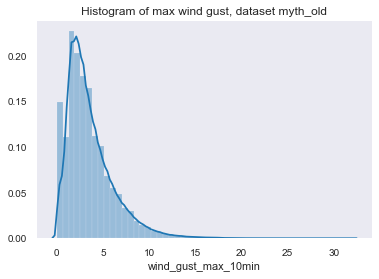

In [43]:
sns.distplot(myth_old.wind_gust_max_10min)
sns.set(rc={'figure.figsize':(8,5)})
plt.title('Histogram of max wind gust, dataset myth_old');

Die Funktion wind_prob testet die Windgeschwindigkeiten eines Datasets auf seine Verteilung. Und gibt die Wahrscheinlichkeit dass eine Starkwindwarnung oder Sturmwarnung an diesem Tag auftriff anhand der historischen Daten an.

In [44]:
%matplotlib inline
# Use:  gives out prediction of wind (warings for strong and storm wind) in percent
# Parameters: data = dataset with columns called 'timestamp_cet' and 'wind_gust_max_10min'
def wind_prob(data):
    
    matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
    matplotlib.style.use('ggplot')

    # Create models from data
    def best_fit_distribution(data, bins=200):
        global best_distribution
        """Model data by finding best fit distribution to data"""
        # Get histogram of original data
        y, x = np.histogram(data, bins=bins, density=True)
        x = (x + np.roll(x, -1))[:-1] / 2.0

        # Distributions to check
        DISTRIBUTIONS = [        
            st.dgamma,st.expon,st.exponnorm, st.gamma,st.gengamma,st.invgamma,st.invgauss,
            st.invweibull,st.johnsonsb, st.laplace, st.logistic,st.loggamma,st.loglaplace,
            st.lognorm,st.norm,st.weibull_min,st.weibull_max
        ]

        # Best holders
        best_distribution = st.norm
        best_params = (0.0, 1.0)
        best_sse = np.inf

        # Estimate distribution parameters from data
        for distribution in DISTRIBUTIONS:

            # Try to fit the distribution
            try:
                # Ignore warnings from data that can't be fit
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore')

                    # fit dist to data
                    params = distribution.fit(data)

                    # Separate parts of parameters
                    arg = params[:-2]
                    loc = params[-2]
                    scale = params[-1]

                    # Calculate fitted PDF and error with fit in distribution
                    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                    sse = np.sum(np.power(y - pdf, 2.0))



                    # identify if this distribution is better
                    if best_sse > sse > 0:
                        best_distribution = distribution
                        best_params = params
                        best_sse = sse

            except Exception:
                pass

        return (best_distribution.name, best_params)

    def make_pdf(dist, params, size=10000):
        """Generate distributions's Probability Distribution Function """

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Get sane start and end points of distribution
        start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
        end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

        # Build PDF and turn into pandas Series
        x = np.linspace(start, end, size)
        y = dist.cdf(x, loc=loc, scale=scale, *arg)
        pdf = pd.Series(y, x)

        return pdf

    # Load data from statsmodels datasets
    data = data.set_index('timestamp_cet')
    data = data.wind_gust_max_10min


    # Find best fit distribution
    best_fit_name, best_fit_params = best_fit_distribution(data, 10)
    best_dist = getattr(st, best_fit_name)


    # Make PDF with best params 
    pdf = make_pdf(best_dist, best_fit_params)

    # Display
    '''plt.figure(figsize=(12,8))
    pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    plt.title(dist_str)
    plt.xlabel(u'Wind Gust')
    plt.ylabel('Frequency')'''
    
    pdf = pdf.to_frame()
    
    try:
        values_above_12 = pdf[pdf.index > 12.7]
        val = values_above_12.iloc[0][0]
        prob_strong_wind = (1- val)*100
    except:
        prob_strong_wind = 0
    
    try:
        values_above_12 = pdf[pdf.index > 16.9]
        val = values_above_12.iloc[0][0]
        prob_sturm_wind = (1 - val)*100
    except:
        prob_sturm_wind = 0
    
    return prob_strong_wind, prob_sturm_wind
'''
More possible distributions:

st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy''';

In [45]:
wind_prob(test)

(1.2577819779378996, 0)

## 6. Niederschlag
Dem Datenset Tiefenbrunnen fehlt das Feature 'precipitation' (engl. Niederschlag). Ich gehe allerdings davon aus dass wenn es beim Mythenquai regnet es auch bei der Station Tiefenbrunnen regnet. 
Ziel ist es nun Informationen zum Tag zu geben, in der Form von "In den letzten 15 Jahren hat es 12 von 15 Mal an diesem Tag geregnet"

Dazu sammle ich die Niederschlagsdaten zu diesem Tag aus jedem Jahr und summiere diese auf:

Die Funktion 'query_percipitation' summiert alle Tage (mit selbem Datum pro Jahr) in denen Regen gefallen ist und gibt die Anzahl Jahre in denen es geregnet hat und die totale Anzahl Jahre zurück, damit diese Informationen in einem Satz wie 'In den letzten X Jahren hat es Y von X geregnet' dargestellt werden können.

In [46]:
# Use:  Gives out the sentence 'In den letzten X Jahren hat es Y von X mal geregnet.'
# Parameters: data = dataset with column called 'timestamp_cet' and 'precipitation'
def query_percipitation(data):
    now = datetime.datetime.now()
    month = now.month
    result = data.set_index(data.timestamp_cet)
    result = data[(data['timestamp_cet'].dt.month==now.month) & (data['timestamp_cet'].dt.day==now.day)]
    grouped = result.groupby(by=result['timestamp_cet'].dt.date).sum()
    rain = 0
    years = len(grouped)
    for x in grouped['precipitation']:
        if x > 0:
            rain += 1
    return rain, years

In [47]:
query_percipitation(myth_old)

(3, 11)

In [48]:
# Use:  pulls Data in a two week range of a dataset with the current date in the middle (for every year in the dataset)
# Parameters: data = dataset with a column called 'timestamp_cet' (in datetime format)
def prob_precipitation(data):
    now = datetime.datetime.now()
    month = data[(data['timestamp_cet'].dt.month==now.month) & (data['timestamp_cet'].dt.day > (now.day -3)) & (data['timestamp_cet'].dt.day < (now.day + 3))]   
    return month

In [49]:
'''
# Use:  gives out prediction of rain (precipitation over 0mm) in percent
# Parameters: data = dataset containing a column called 'precipitation' with numerical values
def rain_prob(data):
    
    matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
    matplotlib.style.use('ggplot')

    # Create models from data
    def best_fit_distribution(data, bins=200):
        global best_distribution
        """Model data by finding best fit distribution to data"""
        # Get histogram of original data
        y, x = np.histogram(data, bins=bins, density=True)
        x = (x + np.roll(x, -1))[:-1] / 2.0

        # Distributions to check
        DISTRIBUTIONS = [        
            st.dgamma,st.expon,st.exponnorm, st.gamma,st.gengamma,st.invgamma,st.invgauss,
             st.invweibull,st.johnsonsb, st.laplace, st.logistic,st.loggamma,st.loglaplace,
            st.lognorm,st.norm,st.weibull_min,st.weibull_max
        ]

        # Best holders
        best_distribution = st.norm
        best_params = (0.0, 1.0)
        best_sse = np.inf

        # Estimate distribution parameters from data
        for distribution in DISTRIBUTIONS:

            # Try to fit the distribution
            try:
                # Ignore warnings from data that can't be fit
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore')

                    # fit dist to data
                    params = distribution.fit(data)

                    # Separate parts of parameters
                    arg = params[:-2]
                    loc = params[-2]
                    scale = params[-1]

                    # Calculate fitted PDF and error with fit in distribution
                    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                    sse = np.sum(np.power(y - pdf, 2.0))



                    # identify if this distribution is better
                    if best_sse > sse > 0:
                        best_distribution = distribution
                        best_params = params
                        best_sse = sse

            except Exception:
                pass

        return (best_distribution.name, best_params)

    def make_pdf(dist, params, size=10000):
        """Generate distributions's Probability Distribution Function """

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Get sane start and end points of distribution
        start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
        end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

        # Build PDF and turn into pandas Series
        x = np.linspace(start, end, size)
        y = dist.cdf(x, loc=loc, scale=scale, *arg)
        pdf = pd.Series(y, x)

        return pdf

    # Load data from statsmodels datasets
    data = data.precipitation

    # Find best fit distribution
    best_fit_name, best_fit_params = best_fit_distribution(data, 10)
    best_dist = getattr(st, best_fit_name)

    # Make PDF with best params 
    pdf = make_pdf(best_dist, best_fit_params)

    pdf = pdf.to_frame()
    
    values_above_1 = pdf[pdf.index > 1]
    val = values_above_1.iloc[0][0]
    prob_rain = (1- val)*100
        
    return prob_rain'''

'\n# Use:  gives out prediction of rain (precipitation over 0mm) in percent\n# Parameters: data = dataset containing a column called \'precipitation\' with numerical values\ndef rain_prob(data):\n    \n    matplotlib.rcParams[\'figure.figsize\'] = (16.0, 12.0)\n    matplotlib.style.use(\'ggplot\')\n\n    # Create models from data\n    def best_fit_distribution(data, bins=200):\n        global best_distribution\n        """Model data by finding best fit distribution to data"""\n        # Get histogram of original data\n        y, x = np.histogram(data, bins=bins, density=True)\n        x = (x + np.roll(x, -1))[:-1] / 2.0\n\n        # Distributions to check\n        DISTRIBUTIONS = [        \n            st.dgamma,st.expon,st.exponnorm, st.gamma,st.gengamma,st.invgamma,st.invgauss,\n             st.invweibull,st.johnsonsb, st.laplace, st.logistic,st.loggamma,st.loglaplace,\n            st.lognorm,st.norm,st.weibull_min,st.weibull_max\n        ]\n\n        # Best holders\n        best_dis

In [50]:
rain_data = prob_precipitation(myth_old)
# print(rain_prob(rain_data))

In [51]:
def rain_prob(data):
    
    matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
    matplotlib.style.use('ggplot')

    # Create models from data
    def best_fit_distribution(data, bins=200):
        global best_distribution
        """Model data by finding best fit distribution to data"""
        # Get histogram of original data
        y, x = np.histogram(data, bins=bins, density=True)
        x = (x + np.roll(x, -1))[:-1] / 2.0

        # Distributions to check
        DISTRIBUTIONS = [        
            st.dgamma,st.expon,st.exponnorm, st.gamma,st.gengamma,st.invgamma,st.invgauss,
            st.invweibull,st.johnsonsb, st.laplace, st.logistic,st.loggamma,st.loglaplace,
            st.lognorm,st.norm,st.weibull_min,st.weibull_max
        ]

        # Best holders
        best_distribution = st.norm
        best_params = (0.0, 1.0)
        best_sse = np.inf

        # Estimate distribution parameters from data
        for distribution in DISTRIBUTIONS:

            # Try to fit the distribution
            try:
                # Ignore warnings from data that can't be fit
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore')

                    # fit dist to data
                    params = distribution.fit(data)

                    # Separate parts of parameters
                    arg = params[:-2]
                    loc = params[-2]
                    scale = params[-1]

                    # Calculate fitted PDF and error with fit in distribution
                    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                    sse = np.sum(np.power(y - pdf, 2.0))



                    # identify if this distribution is better
                    if best_sse > sse > 0:
                        best_distribution = distribution
                        best_params = params
                        best_sse = sse

            except Exception:
                pass

        return (best_distribution.name, best_params)

    def make_pdf(dist, params, size=10000):
        """Generate distributions's Probability Distribution Function """

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Get sane start and end points of distribution
        start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
        end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

        # Build PDF and turn into pandas Series
        x = np.linspace(start, end, size)
        y = dist.cdf(x, loc=loc, scale=scale, *arg)
        pdf = pd.Series(y, x)

        return pdf

    # Load data from statsmodels datasets
    data = data.set_index('timestamp_cet')
    data = data.precipitation


    # Find best fit distribution
    best_fit_name, best_fit_params = best_fit_distribution(data, 10)
    best_dist = getattr(st, best_fit_name)


    # Make PDF with best params 
    pdf = make_pdf(best_dist, best_fit_params)

    # Display
    '''plt.figure(figsize=(12,8))
    pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    plt.title(dist_str)
    plt.xlabel(u'Wind Gust')
    plt.ylabel('Frequency')'''
    
    pdf = pdf.to_frame()
    
    values_above_0 = pdf[pdf.index > 0]
    val = values_above_0.iloc[0][0]
    prob_rain = (1- val)*100
    
    return prob_rain

In [52]:
rain_prob(rain_data)

57.82923002642577

## 7. Erwartete Höchst-, Tiefsttemperatur
Ziel ist es nun Informationen zu der an diesem Tag erwarteten Temperaturschwankung als Höchst- und Tiefsttemperatur zu liefern.

Dazu werden alle Tage mit dem Aktuellen Monat und Tag aus dem Datensatz herausgezogen und der Durchschnitt vom jeweiligen höchsten und tiefsten Wert gebildet.

In [53]:
def query_max_min_per_day(data, column):
    now = datetime.datetime.now()
    result = data.set_index(data.timestamp_cet)
    result = data[(data['timestamp_cet'].dt.month==now.month) & (data['timestamp_cet'].dt.day == (now.day))] 
    max_grouped = result.groupby(by=result['timestamp_cet'].dt.date).max()
    min_grouped = result.groupby(by=result['timestamp_cet'].dt.date).min()
    column_max = max_grouped[column]
    column_min = min_grouped[column]
    mean_max = np.mean(column_max)
    mean_min = np.mean(column_min) 
    return mean_max, mean_min

In [54]:
data = query_max_min_per_day(myth_old, "air_temperature")


print("Max Temperature:", np.round(data[0], 3))
print("Min Temperature:", np.round(data[1], 3))



Max Temperature: 5.118
Min Temperature: -0.282
